# Project 3b

The final part of the project will ask you to perform your own data science project to classify a new dataset.

## Submission Details

**Project is due June 14th at 11:59 pm (Friday Midnight). To submit the project, please save the notebook
as a pdf file and submit the assignment via Gradescope. In addition, make sure that
all figures are legible and suﬀiciently large. For best pdf results, we recommend printing the notebook using [$\LaTeX$](https://www.latex-project.org/)**

## Loading Essentials and Helper Functions 

In [1]:
# fix for windows memory leak with MKL
import os
import platform

if platform.system() == "Windows":
    os.environ["OMP_NUM_THREADS"] = "2"

In [2]:
# import libraries
import time
import random
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt  # this is used for the plot the graph

# Sklearn classes
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    KFold,
    RandomizedSearchCV
)
from sklearn import metrics
from sklearn.metrics import confusion_matrix, silhouette_score
import sklearn.metrics.cluster as smc
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    LabelEncoder,
    MinMaxScaler,
)
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn import tree
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC 
from sklearn.datasets import make_blobs


from helper import (
    draw_confusion_matrix,
    heatmap,
    make_meshgrid,
    plot_contours,
    draw_contour,
)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Sets random seed for reproducibility
SEED = 42
random.seed(SEED)

# (100 pts) Putting it all together: Classify your own data

Through the course of this program, you have acquired knowledge and skills in applying various models to tackle supervised learning tasks. Now, we challenge you to harness your cumulative learning and create a model capable of predicting whether a hotel reservation will be canceled or not.

### Context
Hotels welcome millions of guests every year, and their primary objective is to keep rooms occupied and paid for. Cancellations can be detrimental to the business, as it may become challenging to rebook a room on short notice. Consequently, it is beneficial for hotels to anticipate which reservations are likely to be canceled. The provided dataset offers a diverse range of information about bookings, which you will utilize to predict cancellations.

### Challenge
The goal of this project is to develop a predictive model that can determine whether a reservation will be canceled based on the available input parameters.

While we will provide specific instructions to guide you in the right direction, you have the freedom to choose the models and preprocessing techniques that you deem most appropriate. Upon completion, we request that you provide a detailed description outlining the models you selected and the rationale behind your choices.

### Data Description
Refer to https://www.kaggle.com/competitions/m-148-spring-2024-project-3/data for information

## (50 pts) Preprocessing
For the dataset, the following are mandatory pre-processing steps for your data:

- **Use One-Hot Encoding on all categorical features** (specify whether you keep the extra feature or not for features with multiple values)
- Determine which fields need to be dropped
- **Handle missing values** (Specify your strategy)
- **Rescale the real valued features using any strategy you choose** (StandardScaler, MinMaxScaler, Normalizer, etc)
- **Augment at least one feature**
- **Implement a train-test split with 20% of the data going to the test data**. Make sure that the test and train data are balanced in terms of the desired class.

After writing your preprocessing code, write out a description of what you did for each step and provide a justification for your choices. All descriptions should be written in the markdown cells of the jupyter notebook. Make sure your writing is clear and professional.  

We highly recommend reading through the [scikit-learn documentation](https://scikit-learn.org/stable/data_transforms.html) to make this part easier.

In [3]:
# TODO
hotels = pd.read_csv("datasets/hotel_booking.csv")
hotels.info()
hotels.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69591 entries, 0 to 69590
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           69591 non-null  object 
 1   is_canceled                     69591 non-null  int64  
 2   lead_time                       69591 non-null  int64  
 3   arrival_date_month              69591 non-null  object 
 4   stays_in_weekend_nights         69591 non-null  int64  
 5   stays_in_week_nights            69591 non-null  int64  
 6   adults                          69591 non-null  int64  
 7   children                        69588 non-null  float64
 8   babies                          69591 non-null  int64  
 9   meal                            69591 non-null  object 
 10  country                         69591 non-null  object 
 11  previous_cancellations          69591 non-null  int64  
 12  previous_bookings_not_canceled  

,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,69591.000000,69591.000000,69591.000000,69591.000000,69591.000000,69588.000000,69591.000000,69591.000000,69591.000000,69591.000000,69591.000000,69591.000000,69591.000000,69591.000000
mean,0.405814,109.181546,0.880746,2.434280,1.839088,0.089081,0.008708,0.107571,0.177566,0.203015,2.795031,98.175805,0.065641,0.509060
std,0.491052,113.714559,0.983784,1.852226,0.617512,0.369929,0.105919,0.860100,1.747278,0.597184,19.475713,52.222296,0.248870,0.767946
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,17.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,65.000000,0.000000,0.000000
50%,0.000000,71.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,90.000000,0.000000,0.000000
75%,1.000000,169.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,120.000000,0.000000,1.000000
max,1.000000,709.000000,16.000000,41.000000,55.000000,10.000000,10.000000,26.000000,72.000000,21.000000,391.000000,5400.000000,3.000000,5.000000


Here I visualized the data to see what I am working with in terms of types and features.

In [4]:
hotels = hotels.drop(["name", "email", "phone-number"], axis=1)
y = hotels["is_canceled"]
x = hotels.drop(["is_canceled"], axis=1)

train_raw, test_raw, target, target_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=0)

I dropped the unneccasary personal information of people booking since my model should not take this into account at all.

In [5]:
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

#remove personal information

weekend_ix, week_ix, month_ix = 4, 5, 3

class AugmentFeatures(BaseEstimator, TransformerMixin):
    
    def __init__(self, add_total_nights=True):
        self.add_total_nights = add_total_nights

    def fit(self, X, y=None):
        return self 

    def transform(self, X):
        if self.add_total_nights:
            total_nights = X[:, weekend_ix] + X[:, week_ix]
            return np.c_[X, total_nights]
        else:
            return X

num_pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")), 
        ("attribs_adder", AugmentFeatures(add_total_nights=True)),  
        ("std_scaler", StandardScaler()),
    ]
)

categorical_features = ["hotel", "arrival_date_month", "meal", "country", "reserved_room_type", "deposit_type", "customer_type"]
numerical_features = ["lead_time", "stays_in_weekend_nights", "stays_in_week_nights", "adults", "children", "babies", "previous_cancellations", "previous_bookings_not_canceled", "booking_changes", "days_in_waiting_list", "adr", "required_car_parking_spaces", "total_of_special_requests"]

full_pipeline = ColumnTransformer(
    [
        ("num", num_pipeline, numerical_features),
        ("cat", OneHotEncoder(), categorical_features),
    ]
)

train = full_pipeline.fit_transform(train_raw)
test = full_pipeline.transform(test_raw)



Here I added in a numerical feature which counts the total time that person books instead of two splits for weekdays and weekend days. I also used the OneHotEncoder on all of my categorical data and handled null values by replacing them with the median value for these data points. The null points were numerical values so this was easy to replace and fix.

In [6]:
ct = target_test.value_counts()
print("Counts of each class in target_test: ")
print(ct)
print(
    "==========================================",
    "\nBaseline Accuraccy of using Majority Class:",
    np.round(np.max(ct) / np.sum(ct), 3),
)

Counts of each class in target_test: 
is_canceled
0    8270
1    5649
Name: count, dtype: int64
Baseline Accuraccy of using Majority Class: 0.594


In [7]:
pca = PCA(n_components=0.9)
pca_pipe = Pipeline(
    [
        (
            "scaler",
            StandardScaler(),
        ),  
        ("pca", pca),
    ]
)
pca_pipe.fit(train)

train_pca = pca.fit_transform(train)
test_pca = pca.transform(test)


## (50 pts) Try out a few models
Now that you have pre-processed your data, you are ready to try out different models. 

For this part of the project, we want you to experiment with all the different models demonstrated in the course to determine which one performs best on the dataset.

You must perform classification using at least 3 of the following models:
- Logistic Regression
- K-nearest neighbors
- SVM
- Decision Tree
- Multi-Layer Perceptron

Due to the size of the dataset, be careful which models you use and look at their documentation to see how you should tackle this size issue for each model.

For full credit, you must perform some hyperparameter optimization on your models of choice. You may find the following scikit-learn library on [hyperparameter optimization](https://scikit-learn.org/stable/modules/grid_search.html#grid-search) useful.

For each model chosen, write a description of which models were chosen, which parameters you optimized, and which parameters you choose for your best model. 
While the previous part of the project asked you to pre-process the data in a specific manner, you may alter pre-processing step as you wish to adjust for your chosen classification models.


Accuracy:    0.839141
Confusion Matrix: 
 [[7094 1176]
 [1063 4586]]


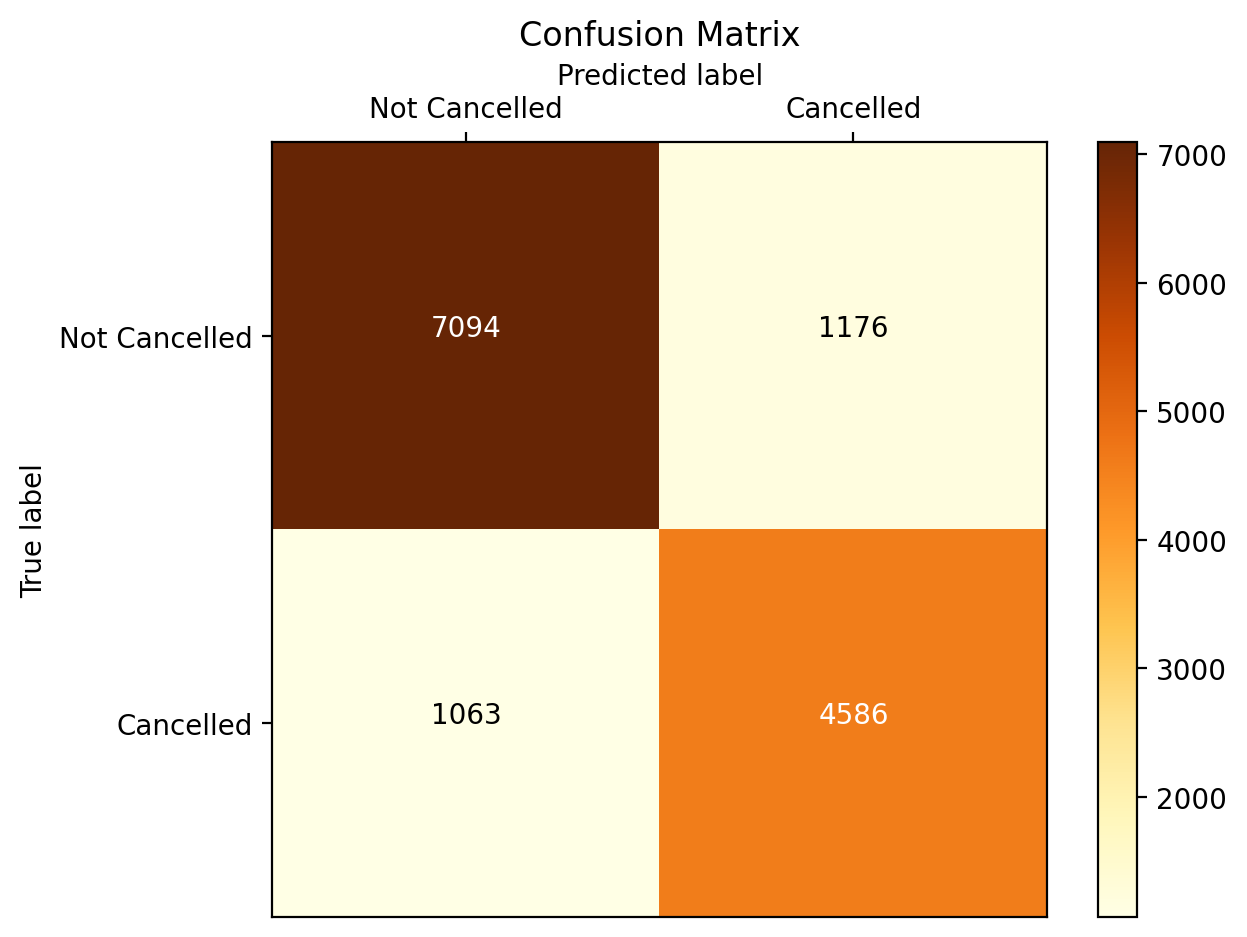

In [8]:
# TODO
dt = DecisionTreeClassifier(random_state=SEED)
dt.fit(train, target)
predicted = dt.predict(test)

print("%-12s %f" % ("Accuracy:", metrics.accuracy_score(target_test, predicted)))
print("Confusion Matrix: \n", metrics.confusion_matrix(target_test, predicted))
draw_confusion_matrix(target_test, predicted, ["Not Cancelled", "Cancelled"])

Accuracy:    0.840649


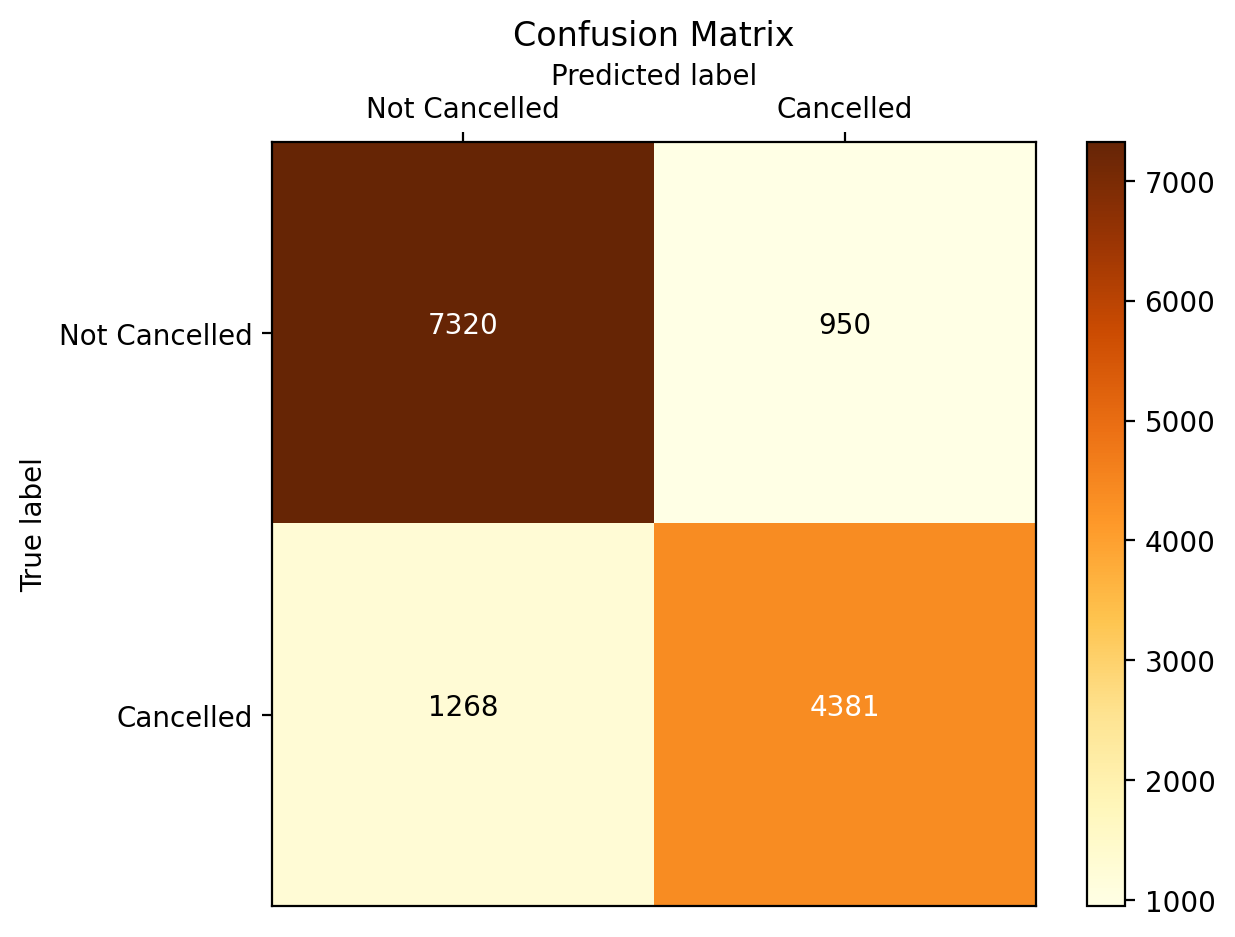

In [9]:
parameters = [
    {
        "max_depth": [2,4,8,16,32],
        "min_samples_split": [2,4,8,16, 32],
        "criterion": ["gini", "entropy"],
    },  
]

kf = KFold(n_splits=5, random_state=None)
grid = GridSearchCV(dt, parameters, cv=kf, scoring="accuracy")
grid.fit(train,target)

best_dt = grid.best_estimator_
best_dt.fit(train, target)

predicted = best_dt.predict(test)

print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test, predicted)))
draw_confusion_matrix(target_test, predicted, ["Not Cancelled", "Cancelled"])


In [10]:
grid.best_params_

{'criterion': 'entropy', 'max_depth': 32, 'min_samples_split': 32}

Performed hyperparameter adjustment with max depth of 32, min samples split of 32, and use of entropy loss instead gini after peformed K Fold cross validation and retrieving the best parameter performance.

Accuracy:    0.859760
Confusion Matrix: 
 [[7597  673]
 [1279 4370]]


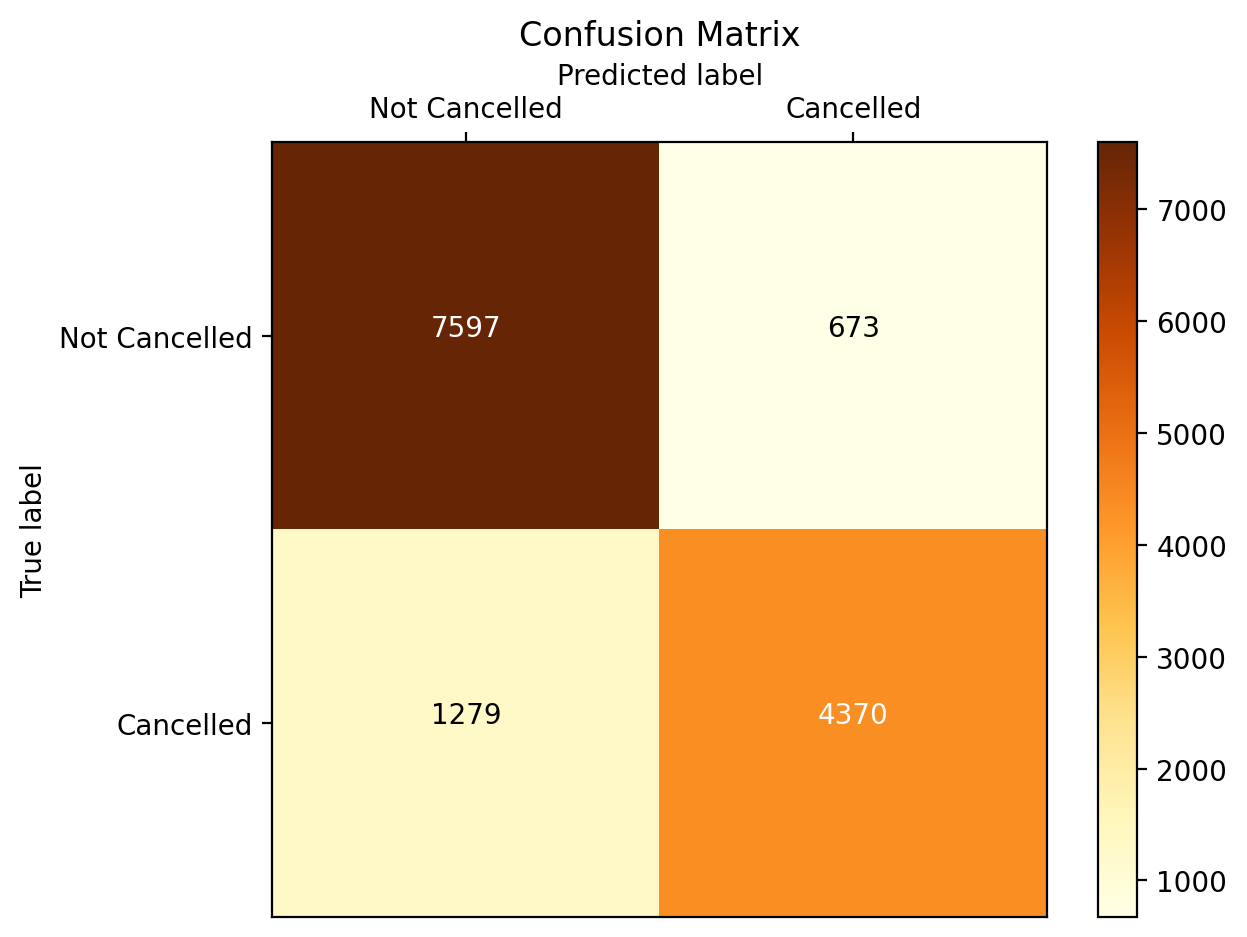

In [11]:
clf = MLPClassifier(hidden_layer_sizes=(15,25), max_iter=1000, random_state=SEED)
clf.fit(train,target)
predicted = clf.predict(test)

print("%-12s %f" % ("Accuracy:", metrics.accuracy_score(target_test, predicted)))
print("Confusion Matrix: \n", metrics.confusion_matrix(target_test, predicted))
draw_confusion_matrix(target_test, predicted, ["Not Cancelled", "Cancelled"])

Adjusted hidden layer size to (15,25) which I found to produce the best accuracy results. I could not use KFold in this instance due to extended computaiton runtime and had to manually perform the hyperparameter adjustments. This was the best model I was able to train with an 86% accuracy percentage and used max iterations of 1000 so convergance was found as well as SEED for random seed to keep things constant.

Accuracy:    0.847690


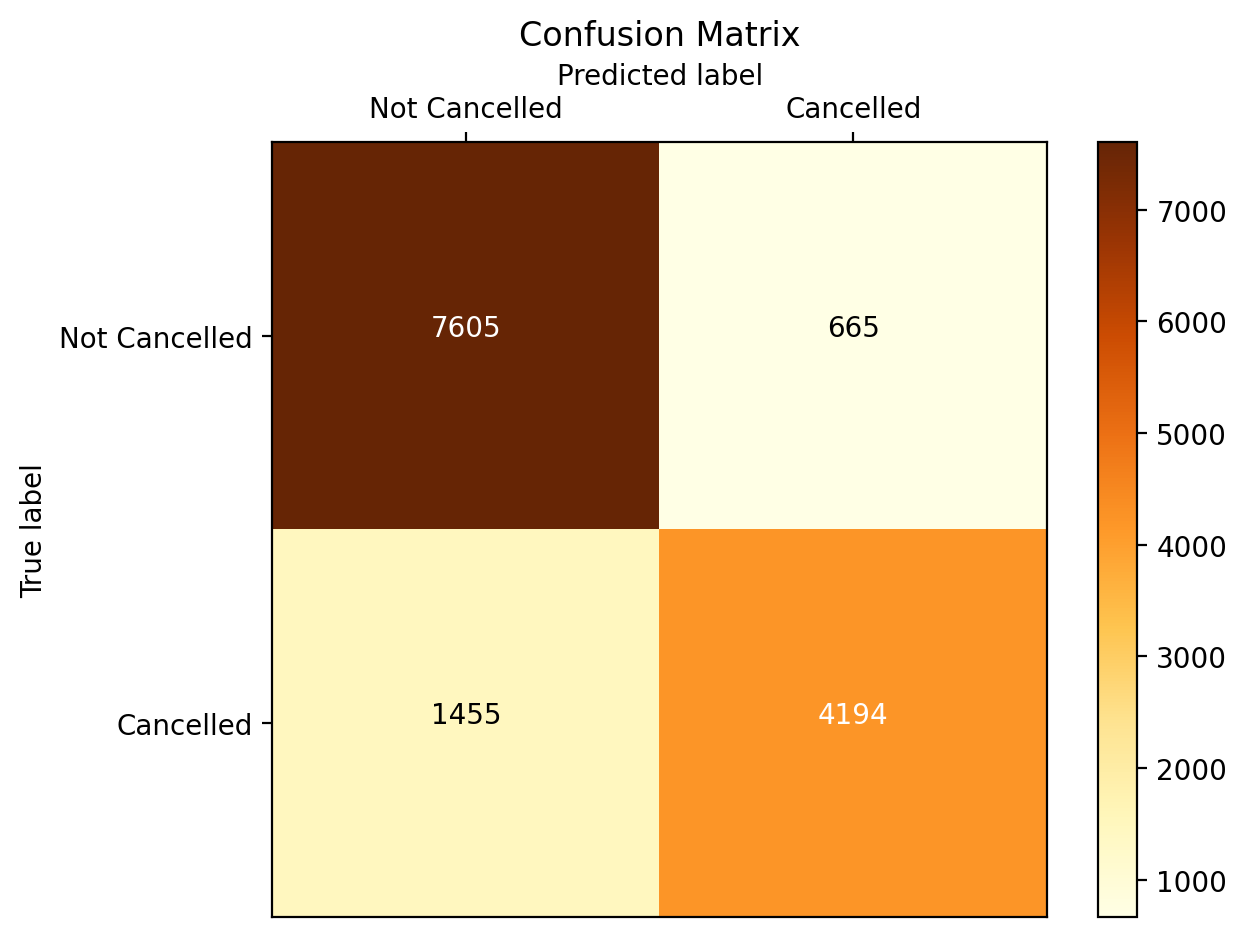

In [12]:
svm = SVC(kernel="rbf", C=50)
parameters = {
    "kernel" : ["rbf","linear"],
    "C" : [0.1, 10] 
    }

#kf = KFold(n_splits=2, random_state=None)
#grid = RandomizedSearchCV(svm, parameters, cv=kf, scoring = "accuracy")
#grid.fit(train_pca,target)

#best_lr = grid.best_estimator_
#best_lr.fit(train_pca, target)

#predicted = best_lr.predict(test_pca)
svm.fit(train_pca, target)
predicted = svm.predict(test_pca)
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test, predicted)))
draw_confusion_matrix(target_test, predicted, ["Not Cancelled", "Cancelled"])

For SVC, I also could not use KFold due to extended runtime but used the rbf kernel and C value of 50 to produce the best accuracy results.

## Extra Credit 

We have provided an extra test dataset named `hotel_booking_test.csv` that does not have the target labels. Classify the samples in the dataset with any method of your choosing and save the predictions into a csv file. Submit the file to our [Kaggle](https://www.kaggle.com/competitions/m-148-spring-2024-project-3/) contest. The website will specify your classification accuracy on the test set. We will award a bonus point for the project for every percentage point over 75% that you get on your kaggle test accuracy.

To get the bonus points, you must also write out a summary of the model that you submit including any changes you made to the pre-processing steps. The summary must be written in a markdown cell of the jupyter notebook. Note that you should not change earlier parts of the project to complete the extra credit.

**Please refer to *Submission and evaluation* section on the contest page for the `csv` file formatting**

### Model description

In [13]:
#TODO
unlabeled = pd.read_csv("datasets/hotel_booking_test.csv")
unlabeled.info()




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17397 entries, 0 to 17396
Data columns (total 23 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           17397 non-null  object 
 1   lead_time                       17397 non-null  int64  
 2   arrival_date_month              17397 non-null  object 
 3   stays_in_weekend_nights         17397 non-null  int64  
 4   stays_in_week_nights            17397 non-null  int64  
 5   adults                          17397 non-null  int64  
 6   children                        17397 non-null  float64
 7   babies                          17397 non-null  int64  
 8   meal                            17397 non-null  object 
 9   country                         17397 non-null  object 
 10  previous_cancellations          17397 non-null  int64  
 11  previous_bookings_not_canceled  17397 non-null  int64  
 12  reserved_room_type              